In [12]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier 
import joblib
import scipy
import torch
from math import erf
from muller_brown_potential_simulations import muller_brown_potential
import matplotlib.pyplot as plt


In [17]:
# load trajectory
#traj=np.load("../data/erik/muller_brown_traj.npy")[:,:,:2]; traj=np.vstack(traj); print(np.shape(traj))

traj=np.load("../data/10000/traj_unperturb.npy")[:1000]; traj=np.vstack(traj)
# load boundary points and boundary predictions 
predict_closest_boundary=joblib.load("../data/module/predict_closest_boundary.joblib")
predict_closest_boundary_A = joblib.load("../data/module/predict_closest_boundary_A.joblib")
predict_closest_boundary_B = joblib.load("../data/module/predict_closest_boundary_B.joblib")

boundary_points=np.load("../data/module/boundary.npy")
boundary_points_A=np.load("../data/module/boundary_A.npy")
boundary_points_B= np.load("../data/module/boundary_B.npy")

boundary=predict_closest_boundary.predict(traj)[:,0]
boundary_A=predict_closest_boundary_A.predict(traj)[:,0]
boundary_B=predict_closest_boundary_B.predict(traj)[:,0]

# define states 
define_state_knn=joblib.load("../data/module/define_state_for_MB_potential.joblib")
knn_result=define_state_knn.predict(traj)  # state a =1; state b =2 ;domain =3
state_a=np.zeros(np.shape(traj)[0]); state_a[np.where(knn_result[:,0]==1)] =1 
state_b=np.zeros(np.shape(traj)[0]); state_b[np.where(knn_result[:,0]==2)] =1
domain=np.zeros(np.shape(traj)[0]); domain[np.where(knn_result[:,0]==3)] =1

# define time-lag index for domain points 
domain_index=np.where(domain==1)[0]
complement_index=np.where(domain==0)[0]
N=len(traj); n_frame_per_traj=5 ;y_ind_range=np.arange(N)
y_ind_range=y_ind_range[np.where(y_ind_range % n_frame_per_traj !=0)[0]]
x_ind_range=y_ind_range-1


In [163]:
def build_gaussian_basis(traj,boundary_points,num_basis):
    num_frame=np.shape(traj)[0]

    # randomly pick 100 frames and compute their mean and variance to build gaussians 
    var_list=[] ;  mu_list1=[] ; basis=[]
    
    mu_list=np.arange(-3,3,0.3)
    mu_list_new=np.arange(-3,3,0.3)
    mu_list=np.meshgrid(mu_list,mu_list_new)
    mu_list=np.asarray(mu_list).reshape((2,400),order='F')
    mu_list=mu_list.T
    print(np.shape(mu_list))
    for x in range(num_basis):

        mu=mu_list[x]
        var=10
        mu_list1.append(mu)
        var_list.append(var)

        for frame in range(num_frame):

            g=np.exp(-1*(np.linalg.norm(traj[frame]-mu)**2)/(2*var))     
            state=int(domain[frame])
            s=1
            if state==1: # point in Domain 
                boundary_index=int(boundary[frame])  
                #if np.linalg.norm(traj[frame]-boundary_points[boundary_index]) < 0.1:
                s_factor=10
                s=0.5*(erf((s_factor)*np.linalg.norm(traj[frame] - boundary_points[boundary_index]) - 3.5) + 1)
            basis.append(g*s)
    
    basis=np.asarray(basis).reshape((num_frame,num_basis),order='F')
    return basis, var_list, mu_list1


In [164]:
result=build_gaussian_basis(traj,boundary_points,400)

(400, 2)


In [165]:
print(result[0])

[[0.00089835 0.00100123 0.00110588 ... 0.00195066 0.00186561 0.00176827]
 [0.01292798 0.01393544 0.01488682 ... 0.01785838 0.01651905 0.01514326]
 [0.34211005 0.37368658 0.40452048 ... 0.63440226 0.59464714 0.55238934]
 ...
 [0.54937447 0.59382049 0.63611148 ... 0.39774486 0.36893021 0.33913704]
 [0.51086705 0.55525416 0.59809077 ... 0.4284207  0.39958329 0.36934783]
 [0.36944011 0.4034955  0.43674173 ... 0.35413006 0.3319024  0.30828283]]


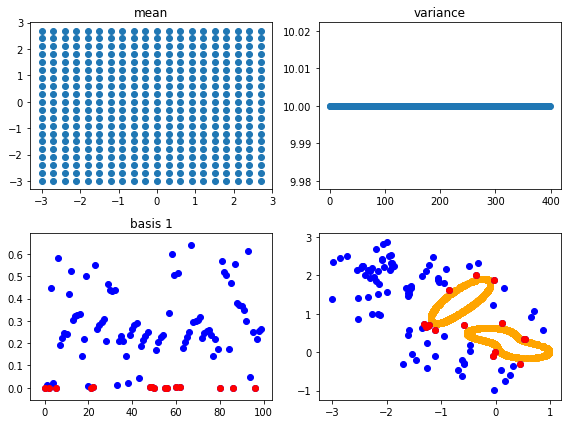

In [167]:
import matplotlib.pyplot as plt
d_index=np.where(domain==1)[0]
fig,ax = plt.subplots(2,2,figsize=(8,6))
ax[0,0].scatter(np.asarray(result[2])[:,0],np.asarray(result[2])[:,1])
ax[0,0].set_title("mean")
ax[0,1].scatter(range(len(result[1])),np.asarray(result[1]))
ax[0,1].set_title("variance")

first_30_points_in_domain=np.asarray(result[0])[:,0][d_index][:100]

highlight=[0, 2, 5, 21, 22, 48, 49, 50, 55, 56, 60, 62, 80, 86, 96]
ax[1,0].scatter(range(100),first_30_points_in_domain,c='b')
ax[1,0].set_title("basis 1")
ax[1,0].scatter(np.asarray(range(100))[highlight],first_30_points_in_domain[highlight],c='r')
#ax[1,0].set_ylim(0,0.001)
ax[1,1].scatter(boundary_points[:,0], boundary_points[:,1],c='orange')

ax[1,1].scatter(traj[d_index][:100][:,0],traj[d_index][:100][:,1],c='b')
ax[1,1].scatter(traj[d_index][highlight][:,0],traj[d_index][highlight][:,1],c='r')

fig.tight_layout()
basis=result[0]

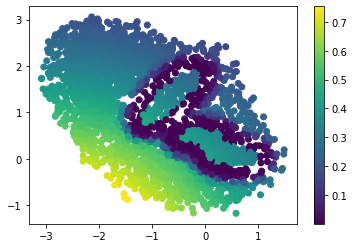

In [173]:
plt.scatter(traj[:,0], traj[:,1], c=result[0][:,1])
plt.colorbar()

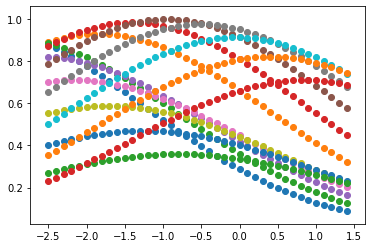

In [166]:
var=result[1]
mu=result[2]
X=np.arange(-2.5,1.5,0.1)
Y=np.arange(-1.5,2.5,0.1)




plt.clf()
for j in range(0,400,30):
    Z=[]
    for i in range(40):
        Z.append( np.exp( -1*np.linalg.norm( np.array([X[i],Y[i]])-mu[j])**2 / (2*var[j])  ) )
    plt.scatter(X,Z)



In [4]:
#basis=np.load("../data/erik/newbasis.npy")


In [64]:
def build_guess_function(traj, state_b, domain):
        domain_index=np.where(domain==1)[0]
        complement_index=np.where(domain==0)[0]     
        
        #assign values to r         
        r=np.zeros(np.shape(domain))
        r[complement_index]=state_b[complement_index]
        
        #compute distance to boundary points 
        for i in range(len(domain)):
            if domain[i]==1:
                ind_A=boundary_A[i]
                ind_B=boundary_B[i]
                dist_A=np.linalg.norm(traj[i]-boundary_points_A[ind_A])
                dist_B=np.linalg.norm(traj[i]-boundary_points_B[ind_B])
                r[i]=(dist_A)/(dist_A + dist_B)  
        return r


In [120]:
def compute_generator(x,y=None, dt=1):

    if y is None :
        y=x

    x_lag=x[x_ind_range]
    y_lag_1=y[x_ind_range]
    y_lag_2=y[y_ind_range]
    N=(len(x_lag))
    L=(x_lag.T .dot (y_lag_2) - x_lag.T .dot(y_lag_1))  *1/(N**2)
    
    return L
     
# Adga=(phix.T@(phiy-phix))
# rdga=phix.T@(ry-rx)
# qdga=phix@np.solve(Adga,-rdga)+rx
 #   else:
  #      return 

def compute_committor(basis, guess, domain, grad_basis=None, force=None,coeff_q0=None):

    
    fLf= compute_generator(basis)
    fLr=compute_generator(basis,guess)
    soln = scipy.linalg.solve(fLf ,-1*fLr )
    diff=basis[x_ind_range] .dot(soln) 
    print(diff)
    
    complement_index=np.where(domain[x_ind_range]==0)[0]
    original_complement_index=np.where(domain==0)[0]
    y=[]
    for x in original_complement_index:
        if x in x_ind_range:
            y.append(x)
    q=diff+guess[x_ind_range]
    q[complement_index]=guess[y]
    print(q)
    q[q>1]=1
    q[q<0]=0
    return q 

   # if coeff_q0 is None:


        
# Adga=(phix.T@(phiy-phix))
# rdga=phix.T@(ry-rx)
# qdga=phix@np.solve(Adga,-rdga)+rx
 #   else:
  #      return 

In [168]:
basis=result[0]
guess=build_guess_function(traj,state_b, domain)
g=compute_committor(basis, guess ,domain)

[-7.51568306e-04 -1.74988995e-02 -8.53102591e-01 ...  2.93818838e-02
  2.30588578e-02  6.62248023e-03]
[0.82091786 0.8667459  1.         ... 0.57354216 0.58614532 0.60104553]


/home/chuhui/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: LinAlgWarning: Ill-conditioned matrix (rcond=2.47979e-20): result may not be accurate.


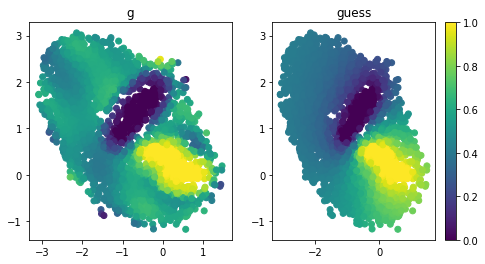

In [169]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
p1=ax[0].scatter(traj[x_ind_range][:,0],traj[x_ind_range][:,1],c=g)
ax[0].set_title("g")
p2=ax[1].scatter(traj[:,0],traj[:,1],c=guess)
ax[1].set_title("guess")
fig.colorbar(p1)


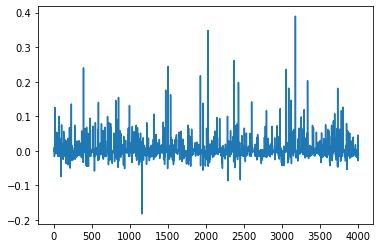

In [100]:
difference=guess[x_ind_range] - g
plt.plot(range(len(x_ind_range)),difference)